In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

# Data

In [4]:
def align(k, window = 5):
    k = np.asarray(k)
    length = k.shape[0]
    for i in range(0, length, 5):
        k[i:i + window] = k[i:i + window]*0 + np.mean(k[i:i + window])
    
    
    return k

def GeneratorOfTimeSeries(n = 50, m = 1000):
    X = np.ones([m, n])*np.linspace(start = 0, stop = 10*np.pi, num = n)
    T1 = []
    T2 = []
    for x in X:
        k = align(np.random.rand(n), 5)
        T1.append(np.sin(k*x) + np.random.randn(n)*0.1)
        T2.append(np.sin(k*x) + np.random.randn(n)*0.1)
        
    T1 = np.asarray(T1)
    T2 = np.asarray(T2)
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1]), np.reshape(T2, [T2.shape[0], T2.shape[1], 1])


In [5]:
X_train, Y_train = GeneratorOfTimeSeries()
X_test, Y_test = GeneratorOfTimeSeries()

# Generator

In [6]:
def batches_generator(batch_size, input, output, shuffle=True, allow_smaller_last_batch=True, device = 'cpu'):
    n_samples = len(input)
    
    list_of_indexes = np.linspace(0, len(input) - 1, len(input), dtype=np.int64)
    list_of_x = []
    list_of_y = []
    
    if shuffle:
        np.random.shuffle(list_of_indexes)
        
    for indx in list_of_indexes:
        list_of_x.append(input[indx])
        list_of_y.append(output[indx])
    
    n_batches = n_samples//batch_size

    if n_samples%batch_size != 0:
        n_batches+=1
        
    for k in range(n_batches):
        this_batch_size = batch_size
        
        if k == n_batches - 1:
            if n_samples%batch_size > 0:
                this_batch_size = n_samples%batch_size
            if allow_smaller_last_batch is False:
                if this_batch_size < batch_size:
                    break

        length_of_sentence_x = 0
        length_of_sentence_y = 0
        for t in range(k*batch_size, k*batch_size + this_batch_size):
            if len(list_of_x[t]) > length_of_sentence_x:
                length_of_sentence_x = len(list_of_x[t])
            if len(list_of_y[t]) > length_of_sentence_y:
                length_of_sentence_y = len(list_of_y[t])
        
        x_arr = np.ones(shape=[this_batch_size, length_of_sentence_x, 1])*0
        y_arr = np.ones(shape=[this_batch_size, length_of_sentence_y, 1])*0
        
        for i in range(this_batch_size):
            for j, (x, y) in enumerate(zip(list_of_x[k*batch_size + i], list_of_y[k*batch_size + i])):
                x_arr[i, j, 0] = x
                y_arr[i, j, 0] = y
                
            
        x_tr = torch.FloatTensor(x_arr)
        y_tr = torch.FloatTensor(y_arr)
        
        x_tr = x_tr.float().to(device)
        y_tr = y_tr.float().to(device)
        yield x_tr, y_tr
    return

# Define Attention

In [7]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def get_scores(self, e, h):
        """
        features: [batch_size x num_objects x obj_feature_dim]
        queries:  [batch_size x num_queries x query_feature_dim]
        Returns matrix of scores with shape [batch_size x num_queries x num_objects].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        raise NotImplementedError()                

    def forward(self, e, h):
        """
        features:        [batch_size x num_objects x obj_feature_dim]
        queries:         [batch_size x num_queries x query_feature_dim]
        Returns matrix of features for queries with shape [batch_size x num_queries x obj_feature_dim].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]     
        
        result has a shape [batch_size, time_len_in_h, dim_e]
        alpha has a shape [batch_size, time_len_in_h, time_len_in_e]
        
        """
        scores = self.get_scores(e, h)
        alphas = F.softmax(scores, 2)
        result = torch.bmm(alphas, e)
        return result, torch.tensor(alphas.detach())
    
class AdditiveAttention(Attention):
    def __init__(self, dim_e, dim_h, hidden_dim):
        """
        obj_feature_dim   - dimensionality of attention object features vector
        query_feature_dim - dimensionality of attention query vector
        hidden_dim        - dimensionality of latent vectors of attention
        
        dim_e      - hidden dimension of encoder
        
        dim_h      - hidden dimension of decoder
    
        hidden_dim        - hidden dimension of attention
        
        
        """
        super(AdditiveAttention, self).__init__()
        
        self.dim_e = dim_e
        self.dim_h = dim_h
        self.hidden_dim = hidden_dim
        
        self.W1 = nn.Linear(dim_e, hidden_dim, bias=False)
        self.W2 = nn.Linear(dim_h, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, 1, bias=False)

    def get_scores(self, e, h):
        """
        features: [batch_size x num_objects x obj_feature_dim]
        queries:  [batch_size x num_queries x query_feature_dim]
        Returns matrix of scores with shape [batch_size x num_queries x num_objects].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        
        """
        f = self.W1(e).view(e.shape[0], 1, e.shape[1], -1)
        q = self.W2(h).view(h.shape[0], h.shape[1], 1, -1)
        a = torch.tanh(f + q)
        result = self.w3(a)[:, :, :, 0]
        return result

# Define seq2seq

In [8]:
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, device = 'cpu'):
        super(seq2seq, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional = False)
        
        self.decoder = nn.LSTM(output_dim + hidden_dim, hidden_dim, num_layers, bidirectional = False)
        
        self.linear = nn.Linear(hidden_dim, output_dim)
    
        self.attention = AdditiveAttention(hidden_dim, hidden_dim, hidden_dim)
        
        self.to(device)
        
    def forward(self, input, max_len = 50):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        max_len is a maximum of generative sentence
        
        return data:
        decoder_out has a shape [batch_size, max_len, output_dim]
    
        """
        input = torch.transpose(input, 0, 1)
        answer = torch.zeros(1, input.shape[1], self.output_dim)
        
        decoder_out = torch.zeros(max_len, input.shape[1], self.output_dim)
        
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        decoder_in = encoder_out[-1].unsqueeze(0)
        encoder_out = torch.transpose(encoder_out, 0, 1)
        

        for i in range(max_len):
            decoder_in = torch.transpose(decoder_in, 0, 1)
            contex, _ = self.attention(encoder_out, decoder_in)
            contex = torch.transpose(contex, 0, 1)
            
            answer = torch.cat((answer, contex), dim = 2)
            
            decoder_in, (encoder_h, encoder_c) = self.decoder(answer, (encoder_h, encoder_c))
            answer = self.linear(decoder_in)
            decoder_out[i] = answer[0]
        
        return torch.transpose(decoder_out, 0, 1)
    
    def train_on_batch(self, x_batch, y_batch, optimizer, loss_function):
        """
        x_batch has a shape [batch_size, time_len_in, input_dim]
        y_batch has a shape [batch_size, time_len_out, output_dim]
        """
        self.zero_grad()
        output = self.forward(x_batch, max_len = y_batch.shape[1])
    
        loss = loss_function(output, y_batch)
        loss.backward()

        optimizer.step()
        
        return
    
    def pred_loss(self, x_batch, y_batch, loss_function):
        output = self.forward(x_batch, max_len = y_batch.shape[1])
        
        return loss_function(output, y_batch)

    def get_attention(self, input, max_len = 50):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        max_len is a maximum of generative sentence
        
        return data:
        decoder_out has a shape [batch_size, max_len, output_dim]
        alphas has a shape [batch_size, max_len, time_len_in_e]
    
        """
        input = torch.transpose(input, 0, 1)
        answer = torch.zeros(1, input.shape[1], self.output_dim)
        
        decoder_out = torch.zeros(max_len, input.shape[1], self.output_dim)
        
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        decoder_in = encoder_out[-1].unsqueeze(0)
        encoder_out = torch.transpose(encoder_out, 0, 1)
        
        alphas = torch.zeros(input.shape[1], max_len, input.shape[0])

        for i in range(max_len):
            decoder_in = torch.transpose(decoder_in, 0, 1)
            contex, alpha = self.attention(encoder_out, decoder_in)
            contex = torch.transpose(contex, 0, 1)
            alphas[:, i, :] = alpha[:,0,:] 
            
            answer = torch.cat((answer, contex), dim = 2)
            
            decoder_in, (encoder_h, encoder_c) = self.decoder(answer, (encoder_h, encoder_c))
            answer = self.linear(decoder_in)
            decoder_out[i] = answer[0]
        
        return torch.transpose(decoder_out, 0, 1), alphas

# Train model

In [9]:
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        model.train_on_batch(batch_of_x, batch_of_y, optimizer, loss_function)
    return

In [10]:
def trainer(count_of_epoch, batch_size, 
            X_train, Y_train, X_test, Y_test,
            model, loss_function,
            optimizer, print_results=True, gamma = 0.9, lr = 0.05):
    
    list_of_loss_train = []
    list_of_loss_test = []
    
    X_test_tr = torch.Tensor(X_test)
    X_train_tr = torch.Tensor(X_train)
    
    Y_train_tr = torch.Tensor(Y_train)
    Y_test_tr = torch.Tensor(Y_test)
    for it in tqdm(range(count_of_epoch)):
        optima = optimizer(model.parameters(), lr=lr*(gamma**it))
        batch_generator = batches_generator(
                                            batch_size=batch_size,
                                            input=X_train,
                                            output=Y_train,
                                            shuffle=True,
                                            allow_smaller_last_batch=True
                                        )
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima)
        
        model.eval()
        
        list_of_loss_train.append(model.pred_loss(X_train_tr, Y_train_tr, loss_function).data.numpy())
        list_of_loss_test.append(model.pred_loss(X_test_tr, Y_test_tr, loss_function).data.numpy())
        
    return list_of_loss_train, list_of_loss_test
        

# Define model

In [11]:
# model = LSTM(input_dim = 1, hidden_dim = 10, output_dim = 1, num_layers = 3)

In [12]:
model = seq2seq(input_dim = 1, hidden_dim = 20, output_dim = 1, num_layers = 1)

In [19]:
list_of_train_loss, list_of_test_loss = trainer(count_of_epoch = 500,
                                                batch_size = 64,
                                                X_train = X_train,
                                                Y_train = Y_train,
                                                X_test = X_test,
                                                Y_test = Y_test,
                                                model = model,
                                                loss_function = torch.nn.MSELoss(),
                                                optimizer = torch.optim.Adam,
                                               )

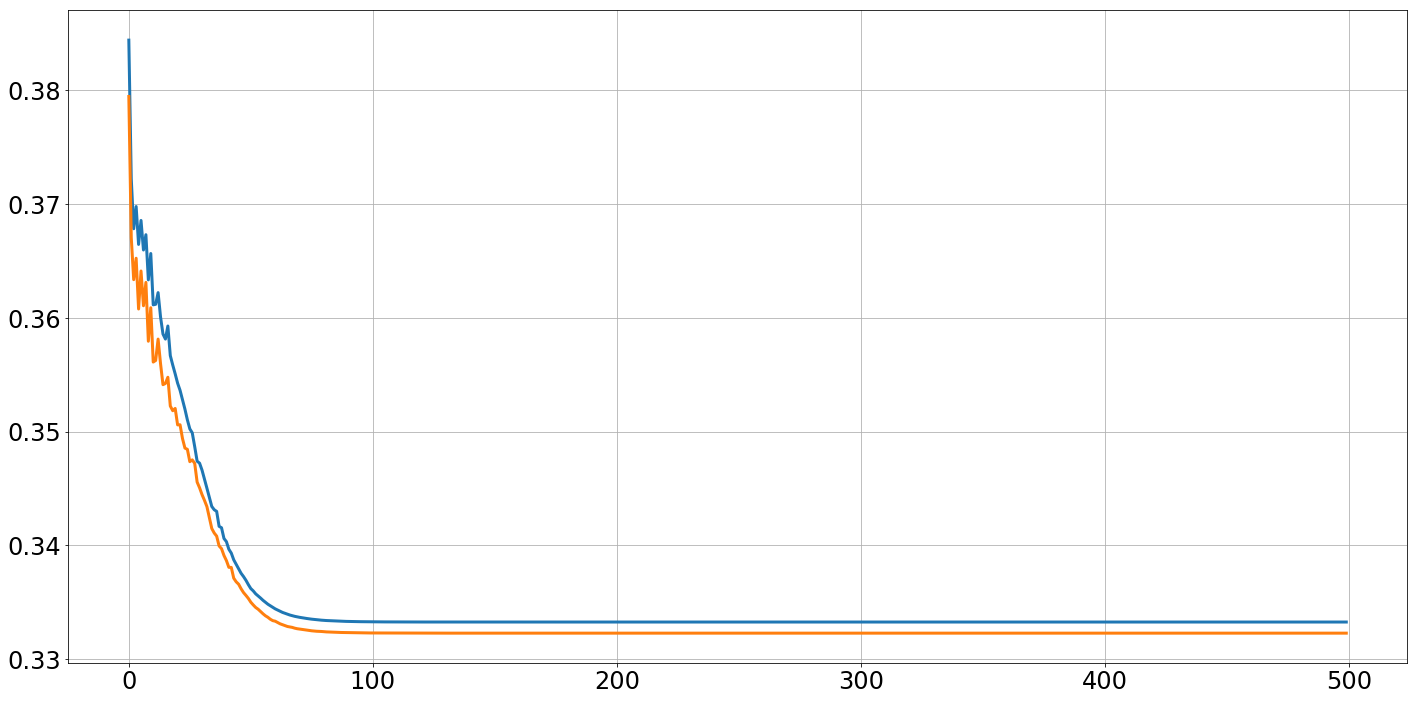

In [20]:
plt.plot(list_of_train_loss)
plt.plot(list_of_test_loss)

plt.grid()

plt.show()

In [21]:
tr_X = torch.Tensor(X_train)
tr_Y = torch.Tensor(Y_train)

In [22]:
M = 16
res, alphas = model.get_attention(tr_X[M-1:M])

In [23]:
alphas[0, 40, :]

tensor([0.0212, 0.0193, 0.0182, 0.0164, 0.0140, 0.0114, 0.0106, 0.0165, 0.0204,
        0.0237, 0.0185, 0.0164, 0.0142, 0.0137, 0.0147, 0.0224, 0.0217, 0.0212,
        0.0210, 0.0211, 0.0201, 0.0211, 0.0204, 0.0209, 0.0215, 0.0198, 0.0218,
        0.0216, 0.0215, 0.0216, 0.0214, 0.0213, 0.0211, 0.0209, 0.0207, 0.0217,
        0.0205, 0.0203, 0.0205, 0.0211, 0.0201, 0.0211, 0.0204, 0.0206, 0.0215,
        0.0216, 0.0228, 0.0235, 0.0252, 0.0268])

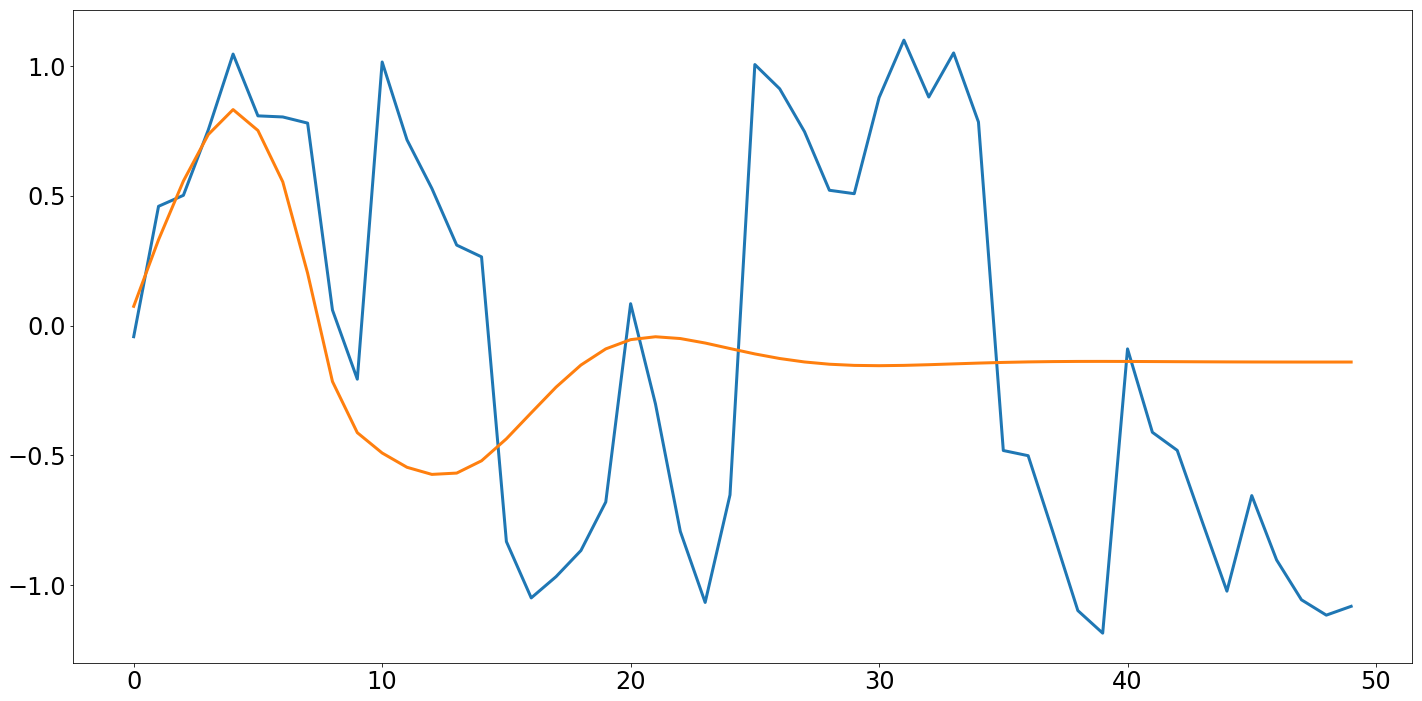

In [24]:
M = 16
plt.plot(np.reshape(np.array(tr_Y[M-1:M]), [-1]))
plt.plot(np.reshape(np.array(model(tr_X[M-1:M]).detach()), [-1]))